# **Visualisation des parcelles dédiées à l'agriculture biologique en France** 

## Contexte du projet
Dans le cadre de ce projet, l'objectif est d'analyser et de visualiser les parcelles agricoles certifiées en agriculture biologique en France. Le but est de mieux comprendre leur répartition géographique et leur importance relative selon les régions et les départements. Cela permettra de fournir une vision claire et exploitable des données, tout en mettant en lumière les disparités territoriales et les tendances actuelles.

## Partie dédiée au mapping
Pour cette partie spécifique du projet, nous utilisons des données géospatiales représentant les parcelles agricoles en France. Ces données initiales sont souvent volumineuses et complexes à traiter directement, notamment à cause des colonnes contenant des informations sur la géométrie (geometry).

### Rôle du code
Le code est conçu pour :
- Charger les données géospatiales provenant de fichiers (par exemple, shapefiles ou GeoJSON).
- Effectuer les transformations nécessaires, y compris le nettoyage, le regroupement et l'agrégation.
- Générer une carte thématique des parcelles biologiques, en utilisant des outils de visualisation comme `folium` ou `matplotlib` pour représenter les données par département.

### Technologies et bibliothèques utilisées
- **Python** : Langage principal pour le traitement des données et la création des visualisations.
- **Pandas** : Pour la manipulation et l'analyse des données tabulaires.
- **Geopandas** : Pour le traitement des données géospatiales.
- **Matplotlib/Folium** : Pour les visualisations cartographiques.

In [45]:
!pip install chardet 
!pip install nbformat 

In [2]:
import requests
import zipfile
import os
import pandas as pd

# URL du fichier ZIP
url_zip = "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29"

# Chemin pour stocker temporairement le fichier ZIP
zip_path = "data.zip"

# Télécharger le fichier ZIP
response = requests.get(url_zip)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Extraire le contenu du fichier ZIP
extract_path = "data_extracted"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Identifier les fichiers extraits (y compris sous-dossiers)
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            df = pd.read_csv(csv_path)
            print("Aperçu du fichier CSV chargé :")
            print(df.head())
        elif file.endswith(".shp"):
            import geopandas as gpd
            shp_path = os.path.join(root, file)
            gdf = gpd.read_file(shp_path)
            print("Aperçu du fichier SHP chargé :")
            print(gdf.head())


/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: data_extracted/rpg-bio-2023-national/rpg-bio-2023-national.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Aperçu du fichier SHP chargé :
       gid  millesime code_cultu precision_  \
0  1057718       2023        SPH       None   
1  1057720       2023        MCR        001   
2  1057733       2023        LUZ        002   
3  1045691       2023        SPH       None   
4  1063649       2023        MLG        001   

                                          lbl_cultur         grp_cultur  \
0  Prairie avec herbe prédominante et ressources ...  Estives et landes   
1  Mélange de céréales ou pseudo-céréales d'hiver...    Autres céréales   
2                                      Autre luzerne           Fourrage   
3  Prairie avec herbe prédominante et ressources ...  Estives et landes   
4  Mélange de légumineuses prépondérantes et de g...           Fourrage   

   surface_ha code_commu         lbl_commun    code_epci code_depar  \
0        0.56      12294  Vézins-de-Lévézou  241200765.0         12   
1        2.22      12294  Vézins-de-Lévézou  241200765.0         12   
2        1.28      123

In [3]:
# Créer une nouvelle variable en supprimant la colonne 'geometry'
gdf_filtered_2023 = gdf.drop(columns=['geometry'])

# Afficher les premières lignes pour vérifier
print("Aperçu des données sans la colonne 'geometry' :")
print(gdf_filtered_2023.head())


Aperçu des données sans la colonne 'geometry' :
       gid  millesime code_cultu precision_  \
0  1057718       2023        SPH       None   
1  1057720       2023        MCR        001   
2  1057733       2023        LUZ        002   
3  1045691       2023        SPH       None   
4  1063649       2023        MLG        001   

                                          lbl_cultur         grp_cultur  \
0  Prairie avec herbe prédominante et ressources ...  Estives et landes   
1  Mélange de céréales ou pseudo-céréales d'hiver...    Autres céréales   
2                                      Autre luzerne           Fourrage   
3  Prairie avec herbe prédominante et ressources ...  Estives et landes   
4  Mélange de légumineuses prépondérantes et de g...           Fourrage   

   surface_ha code_commu         lbl_commun    code_epci code_depar  \
0        0.56      12294  Vézins-de-Lévézou  241200765.0         12   
1        2.22      12294  Vézins-de-Lévézou  241200765.0         12   
2    

In [4]:
import matplotlib.pyplot as plt

# Étape 1 : Compter le nombre de parcelles biologiques par département
parcelles_par_departement = gdf_filtered_2023['code_depar'].value_counts().reset_index()
parcelles_par_departement.columns = ['code_departement', 'nombre_parcelles']

# Étape 2 : Agréger la surface totale des parcelles biologiques par département
surface_par_departement = gdf_filtered_2023.groupby('code_depar')['surface_ha'].sum().reset_index()
surface_par_departement.columns = ['code_departement', 'surface_totale_ha']

# Fusionner les deux DataFrames pour avoir les deux informations
resultat = parcelles_par_departement.merge(surface_par_departement, on='code_departement')

# Trier les départements par surface totale (ou nombre de parcelles si préféré)
resultat = resultat.sort_values(by='surface_totale_ha', ascending=False)

# Afficher les résultats
print("Départements avec le plus de parcelles biologiques :")
print(resultat)



Départements avec le plus de parcelles biologiques :
   code_departement  nombre_parcelles  surface_totale_ha
2                32             36484          115319.18
58               65              7900          103096.45
1                44             39764           87245.72
4                12             31583           77857.75
3                11             32074           68744.30
..              ...               ...                ...
92              972               679             626.78
96              976               102              73.61
98               93                24              60.55
97               94                39              54.30
99              978                 4              44.83

[100 rows x 3 columns]


In [7]:
# Dictionnaire code_region -> nom de la région (métropole)
region_mapping = {
    '11': 'Île-de-France',
    '24': 'Centre-Val de Loire',
    '27': 'Bourgogne-Franche-Comté',
    '28': 'Normandie',
    '32': 'Hauts-de-France',
    '44': 'Grand Est',
    '52': 'Pays de la Loire',
    '53': 'Bretagne',
    '75': 'Nouvelle-Aquitaine',
    '76': 'Occitanie',
    '84': 'Auvergne-Rhône-Alpes',
    '93': 'Provence-Alpes-Côte d\'Azur',
    '94': 'Corse'
}

# Filtrer le DataFrame pour ne garder que les codes régions métropolitaines
gdf_filtered_2023 = gdf_filtered_2023[gdf_filtered_2023['code_regio'].astype(str).isin(region_mapping.keys())]

# Créer une colonne nom_region à partir des codes
gdf_filtered_2023['nom_region'] = gdf_filtered_2023['code_regio'].astype(str).map(region_mapping)

# Vérification
print(gdf_filtered_2023[['code_regio', 'nom_region']].drop_duplicates())


        code_regio                  nom_region
0               76                   Occitanie
54              93  Provence-Alpes-Côte d'Azur
183             27     Bourgogne-Franche-Comté
217             75          Nouvelle-Aquitaine
849             28                   Normandie
858             84        Auvergne-Rhône-Alpes
1694            24         Centre-Val de Loire
13073           53                    Bretagne
27685           44                   Grand Est
76926           11               Île-de-France
79321           94                       Corse
141334          52            Pays de la Loire
248525          32             Hauts-de-France


/tmp/ipykernel_65617/1810471358.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_filtered_2023['nom_region'] = gdf_filtered_2023['code_regio'].astype(str).map(region_mapping)


In [8]:
gdf_filtered_2023.head()

,gid,millesime,code_cultu,precision_,lbl_cultur,grp_cultur,surface_ha,code_commu,lbl_commun,code_epci,code_depar,code_regio,zone_geo,nom_region
0,1057718,2023,SPH,None,Prairie avec herbe prédominante et ressources ...,Estives et landes,0.56,12294,Vézins-de-Lévézou,241200765.0,12,76,France mét.,Occitanie
1,1057720,2023,MCR,001,Mélange de céréales ou pseudo-céréales d'hiver...,Autres céréales,2.22,12294,Vézins-de-Lévézou,241200765.0,12,76,France mét.,Occitanie
2,1057733,2023,LUZ,002,Autre luzerne,Fourrage,1.28,12303,Vimenet,200068484.0,12,76,France mét.,Occitanie
3,1045691,2023,SPH,None,Prairie avec herbe prédominante et ressources ...,Estives et landes,10.78,12145,Millau,241200567.0,12,76,France mét.,Occitanie
4,1063649,2023,MLG,001,Mélange de légumineuses prépondérantes et de g...,Fourrage,2.77,12059,Castanet,200068831.0,12,76,France mét.,Occitanie


In [33]:
# Téléchargement du support de la map pour visualisation data
gdf_france= 'https://france-geojson.gregoiredavid.fr/repo/regions.geojson'
gdf_departements = gpd.read_file(gdf_france)
gdf_counts = gdf_filtered_2023.groupby('nom_region').size().reset_index(name='nb_parcelles_bio')



In [34]:
# Si code_regio est de type int
metropolitan_codes = [11,24,27,28,32,44,52,53,75,76,84,93,94]
gdf_metropole = gdf_filtered_2023[gdf_filtered_2023['code_regio'].isin(metropolitan_codes)]
print(gdf_filtered_2023['code_regio'].unique())
total_metropole = len(gdf_metropole)
print("Le nombre total de parcelles bio en métropole est :", total_metropole)

[76 93 27 75 28 84 24 53 44 11 94 52 32]
Le nombre total de parcelles bio en métropole est : 1160919


In [ ]:
#Création d'une variable contenant le ratio de parcelles bio par région
gdf_counts['ratio_parcelles_bio'] = (gdf_counts['nb_parcelles_bio'] / total_metropole) *100
gdf_merged = gdf_departements.merge(gdf_counts, left_on='nom', right_on='nom_region', how='left')
gdf_merged.head()

,code,nom,geometry,nom_region,nb_parcelles_bio,ratio_parcelles_bio
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",Île-de-France,10428.0,0.898254
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ...",Centre-Val de Loire,34573.0,2.978072
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6...",Bourgogne-Franche-Comté,69941.0,6.024624
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,...",Normandie,41039.0,3.535044
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ...",Hauts-de-France,18357.0,1.581247


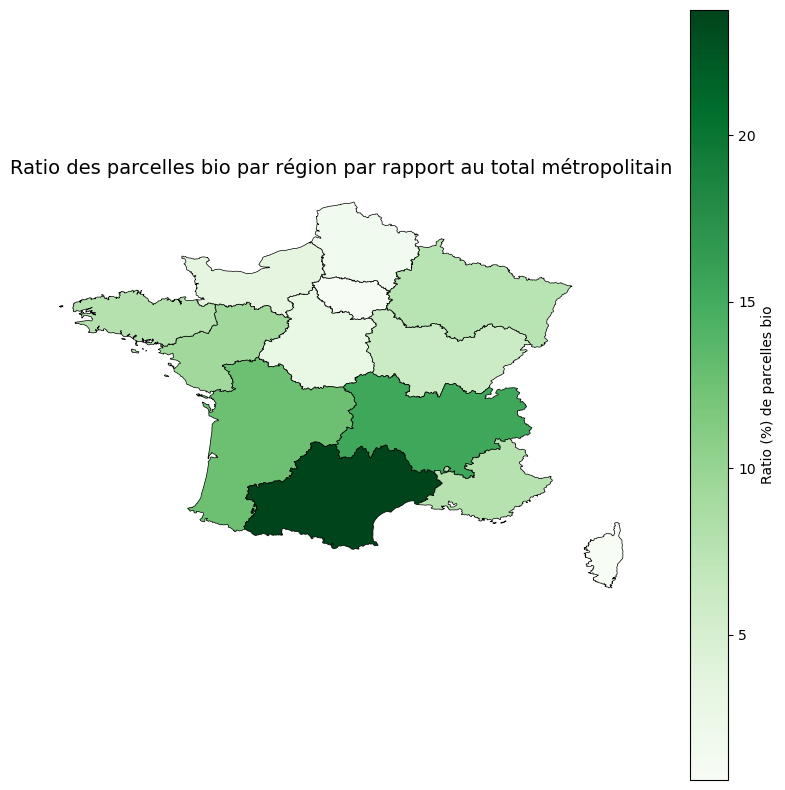

In [38]:
# Visualisation du ratio sur la map de la France 

fig, ax = plt.subplots(figsize=(10,10))
gdf_merged.plot(column='ratio_parcelles_bio', 
                   cmap='Greens', 
                   legend=True,
                   legend_kwds={'label': "Ratio (%) de parcelles bio"},
                   ax=ax,
                   edgecolor='black',
                   linewidth=0.5)


ax.set_title("Ratio des parcelles bio par région par rapport au total métropolitain", fontdict={'fontsize': 14})
ax.axis('off')
plt.show()



## Visualisation sur la carte de la France métropolitaine (départementale)

### Même méthodologie que sur la carte des régions 

In [39]:
#Chargement de la carte des départements
dept_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
gdf_departements = gpd.read_file(dept_url)

In [41]:
# Liste des codes à exclure (DOM-TOM) : 971, 972, 973, 974, 976, etc.
overseas_codes = ['971', '972', '973', '974', '976']
gdf_metropole = gdf_filtered_2023[~gdf_filtered_2023['code_depar'].isin(overseas_codes)]


In [ ]:
# 4. Grouper par département pour obtenir le nombre de parcelles par département
gdf_dep = gdf_metropole.groupby('code_depar').size().reset_index(name='nb_parcelles_bio')

# 5. Calculer le ratio
gdf_dep['ratio_parcelles'] = gdf_dep['nb_parcelles_bio'] / total_metropole * 100


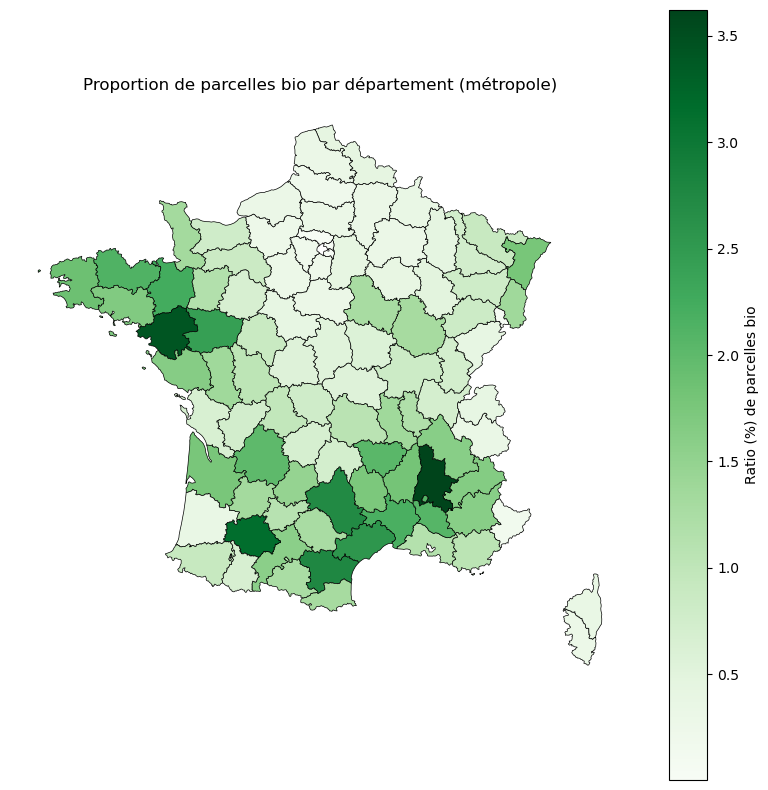

In [44]:
gdf_dep_final = gdf_departements.merge(gdf_dep, how='left', left_on='code', right_on='code_depar')

# 7. Visualiser la carte
fig, ax = plt.subplots(figsize=(10,10))
gdf_dep_final.plot(column='ratio_parcelles', 
                   cmap='Greens', 
                   legend=True,
                   legend_kwds={'label': "Ratio (%) de parcelles bio"},
                   ax=ax,
                   edgecolor='black',
                   linewidth=0.5)

ax.set_title("Proportion de parcelles bio par département (métropole)")
ax.axis('off')
plt.show()

Les résultats obtenus (région et département) sont conformes aux différents mapping de l'INSEE sur les régions les plus agricoles. On s'attend à une proportion plus élevée dans les zones où l'agriculture est déjà très implémentée 
